## Loading in data

In [64]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import *


In [65]:
transactions_df = pd.read_csv("transactions_tm1_e.csv")
customers_df = pd.read_csv("customers_tm1_e.csv")

In [66]:
type(customers_df["creation_date"][0])

str

### changing creation date and dob to date format

In [67]:
#changing creation date and dob to date format
months = []
for n in customers_df["creation_date"]:
    date_str = n
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    months.append(date_obj)
customers_df["creation_date"] = months

In [68]:
months = []
for n in customers_df["dob"]:
    date_str = n
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    months.append(date_obj)
customers_df["dob"] = months

In [69]:
customers_df.head()

,customer_id,dob,state,start_balance,creation_date
0,91,1993-07-01,California,10180.56,2007-01-31
1,92,1985-12-05,New York,4757.68,2007-01-31
2,93,1987-11-19,Minnesota,6796.72,2007-01-31
3,94,1981-03-23,Minnesota,9870.48,2007-01-31
4,95,1970-04-06,California,12500.72,2007-01-31


## Same number of customer_id, account_id combos as there are account_ids and customer_ids (they are the same )

In [70]:
len(customers_df)

116016

In [71]:
transactions_df.head()

,date,account_id,customer_id,amount,transaction_date,deposit,withdrawal
0,2007-01-31,24137947,91,3034.26,2007-01-31,3034.26,0.00
1,2007-01-31,24137947,91,-5295.18,2007-01-16,0.00,-5295.18
2,2007-02-28,24137947,91,0.00,2007-02-28,0.00,0.00
3,2007-03-31,24137947,91,-0.00,2007-03-30,0.00,-0.00
4,2007-03-31,24137947,91,-0.00,2007-03-11,0.00,-0.00


In [72]:
account_ids = transactions_df.account_id.value_counts()

In [73]:
#number of account ids that have made transactions 
print(len(account_ids))

116016


customer_id and account_id are the same 

In [74]:
df2 = transactions_df.groupby(['customer_id','account_id']).agg({'customer_id': ['count'],'account_id': ['count']})
len(df2)

116016

## Agregate by Month

In [75]:
months = []
for n in transactions_df["date"]:
    date_str = n[:7] + "-01"
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    months.append(date_obj)
transactions_df["Date"] = months

In [76]:
transactions_df.head()

,date,account_id,customer_id,amount,transaction_date,deposit,withdrawal,Date
0,2007-01-31,24137947,91,3034.26,2007-01-31,3034.26,0.00,2007-01-01
1,2007-01-31,24137947,91,-5295.18,2007-01-16,0.00,-5295.18,2007-01-01
2,2007-02-28,24137947,91,0.00,2007-02-28,0.00,0.00,2007-02-01
3,2007-03-31,24137947,91,-0.00,2007-03-30,0.00,-0.00,2007-03-01
4,2007-03-31,24137947,91,-0.00,2007-03-11,0.00,-0.00,2007-03-01


In [77]:
grp_df = transactions_df.groupby(['account_id', 'Date', 'customer_id']).agg({'amount': ['sum'], 
                                                                                   'customer_id' : ['count']})
grp_df.columns = ['this_month_transactions', 'this_month_num_transactions']
grp_df = grp_df.reset_index()

## aggregated by month 

In [78]:
grp_df.head()

,account_id,Date,customer_id,this_month_transactions,this_month_num_transactions
0,24137947,2007-01-01,91,-2260.92,2
1,24137947,2007-02-01,91,0.00,1
2,24137947,2007-03-01,91,0.00,3
3,24137948,2007-01-01,92,0.00,1
4,24137948,2007-02-01,92,1164.90,1


### Making sure there are no transactions before the account creation date 

In [79]:
min_date_df = transactions_df.groupby(['account_id', 'customer_id']).agg({'Date': ['min']})
min_date_df.columns = ['min_transaction_date']
min_date_df = min_date_df.reset_index()

In [80]:
min_date_df = min_date_df.join(customers_df.set_index('customer_id'), on='customer_id', how='left', lsuffix='_tran', rsuffix='_cust')

In [81]:
count = 0
for i, n in min_date_df.iterrows():
    cd = str(n["creation_date"])
    md = str(n["min_transaction_date"])
    cdm = cd[5:7]
    mdm = md[5:7]
    if mdm[0] == '0':
        mdm = mdm[1:]
    if cdm[0] == '0':
        cdm = cdm[1:]
    mdm = int(mdm)
    cdm = int(cdm)
    #delta = relativedelta(n["creation_date"] - n["min_transaction_date"])
    if cdm-mdm > 1:
        count += 1
    #print(cdm-mdm)
print(count)

0


In [82]:
min_date_df.head()

,account_id,customer_id,min_transaction_date,dob,state,start_balance,creation_date
0,24137947,91,2007-01-01,1993-07-01,California,10180.56,2007-01-31
1,24137948,92,2007-01-01,1985-12-05,New York,4757.68,2007-01-31
2,24137949,93,2007-01-01,1987-11-19,Minnesota,6796.72,2007-01-31
3,24137950,94,2007-01-01,1981-03-23,Minnesota,9870.48,2007-01-31
4,24137951,95,2007-01-01,1970-04-06,California,12500.72,2007-01-31


## Timeframe of data

In [83]:
print(grp_df['Date'].min())
print(grp_df['Date'].max())
print(len(grp_df))

2007-01-01 00:00:00
2020-05-01 00:00:00
2129121


## adding transaction ids 

In [84]:
transaction_ids = []

for i in range(1,len(grp_df['Date'])+1):
    transaction_ids.append(i)

grp_df["transaction_id"] = transaction_ids


In [85]:
grp_df.head()

,account_id,Date,customer_id,this_month_transactions,this_month_num_transactions,transaction_id
0,24137947,2007-01-01,91,-2260.92,2,1
1,24137947,2007-02-01,91,0.00,1,2
2,24137947,2007-03-01,91,0.00,3,3
3,24137948,2007-01-01,92,0.00,1,4
4,24137948,2007-02-01,92,1164.90,1,5


## keeping track of months with no transactions 

In [86]:

months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

all_dates = []
for i in range(2007,2021):
    for n in months:
        date_str = str(i) + "-" + n + "-01"
        date_obj = datetime.strptime(date_str, '%Y-%m-%d')
        all_dates.append(date_obj)

In [87]:
len(all_dates)

168

#### number of customers that have a transaction every month 

In [88]:
customer_ids = grp_df["customer_id"]
customer_ids = customer_ids.drop_duplicates()
months_of_inactivity_before_this_month = {}
count = 0
for cust_id in customer_ids:
    customer_transactions = grp_df[grp_df["customer_id"] == cust_id]
    customer_transactions = customer_transactions.reset_index()
    if len(customer_transactions) != 161:
        count += 1
print(count)

116008


In [89]:
print(2129121/116016)

18.351960074472487


#### The code below creates a column that counts the months of inactivity before the row 
all of them returned 0. Meaning that all of the transactions for each account_id occur in consecutive months. 
if you uncomment and run the next 3 cells you can see this. 

In [91]:
customer_ids = grp_df["customer_id"]
customer_ids = customer_ids.drop_duplicates()
months_of_inactivity_before_this_month = {}
for cust_id in customer_ids:
    customer_transactions = grp_df[grp_df["customer_id"] == cust_id]
    customer_transactions = customer_transactions.sort_values("Date")
    customer_transactions = customer_transactions.reset_index()
    #print(customer_transactions)
    for i in range(0, len(customer_transactions)):
        #print(i)
        transaction_id = customer_transactions["transaction_id"].iloc[i]
        if i == 0: 
            months_of_inactivity_before_this_month[transaction_id] = 0
            #print(None)
        else:
            cd = customer_transactions["Date"].iloc[i-1]
            md = customer_transactions["Date"].iloc[i]
            month_diff = (md.year - cd.year) * 12 + md.month - cd.month -1
            #print("month_diff " + str(month_diff))
            months_of_inactivity_before_this_month[transaction_id] = month_diff

In [92]:
months_of_inactivity_before_this_month_lst = []
for i in range(1,len(grp_df['Date'])+1):
    months_of_inactivity_before_this_month_lst.append(months_of_inactivity_before_this_month[i])

grp_df["months_of_inactivity_before_this_month"] = months_of_inactivity_before_this_month_lst

In [93]:
count = 0
non_1_count = 0
for n in grp_df["months_of_inactivity_before_this_month"]:
    if n >= 1: #or n is None or n == 'NaN':
        count += 1
    else:
        non_1_count += 1
print(count)
print(non_1_count)

0
2129121


### Adding is_latest_transaction to rows that are the last transaction of an account in the data 

In [94]:
customer_ids = grp_df["customer_id"]
customer_ids = customer_ids.drop_duplicates()
latest_transactions_indices = []
for cust_id in customer_ids:
    transaction_index = grp_df[grp_df["customer_id"] == cust_id]["transaction_id"].idxmax()
    #print(transaction_index)
    #customer_transactions = customer_transactions.sort_values("Date")
    #transaction_index = customer_transactions.index
    latest_transactions_indices.append(transaction_index)

In [95]:
#finish code to add column is_latest_transaction
#get index of latest transaction  and use df.at[index,'column-name']='new value'
is_latest_transaction = []
# for n in grp_df["transaction_id"]:
#     if n in latest_transactions:
#         is_latest_transaction.append(1)
#     else:
#         is_latest_transaction.append(0)
for n in grp_df["transaction_id"]:
    is_latest_transaction.append(0)
grp_df["is_latest_transaction"] = is_latest_transaction
for index in latest_transactions_indices:
    grp_df.at[index,"is_latest_transaction"]=1


In [96]:
#for n in latest_transactions:
    

In [97]:
grp_df.head()

,account_id,Date,customer_id,this_month_transactions,this_month_num_transactions,transaction_id,months_of_inactivity_before_this_month,is_latest_transaction
0,24137947,2007-01-01,91,-2260.92,2,1,0,0
1,24137947,2007-02-01,91,0.00,1,2,0,0
2,24137947,2007-03-01,91,0.00,3,3,0,1
3,24137948,2007-01-01,92,0.00,1,4,0,0
4,24137948,2007-02-01,92,1164.90,1,5,0,0


In [98]:
# customer_ids = grp_df["customer_id"]
# customer_ids = customer_ids.drop_duplicates()
# for cust_id in customer_ids:
#     customer_transactions = grp_df[grp_df["customer_id"] == cust_id]
#     for date in all_dates:
#         date_transactions = customer_transactions[customer_transactions["Date"] == date]
#         #if len(customer_transactions) > 0:
#         if len(date_transactions) == 0:
#             #data = {'account_id': customer_transactions["account_id"][0], 'Date': date, 'customer_id': cust_id, 'this_month_transactions' : 0, 'this_month_num_transactions' : 0}
#             #df2 = pd.DataFrame.from_dict(data, orient='columns')
#             #grp_df = pd.concat([grp_df, df2])
#             grp_df.loc[len(grp_df.index)] = [0, date, cust_id, 0, 0]

#### number of last transactions is the same as the number of accounts (test passed)

In [99]:
count = 0
non_1_count = 0
for n in grp_df["is_latest_transaction"]:
    if n == 1: #or n is None or n == 'NaN':
        count += 1
    else:
        non_1_count += 1
print(count)
print(non_1_count)
#2013105
#116016

116016
2013105


## Get Number of Months of Inactivity 

In [144]:
months_of_inactivity_after_this_month = []
for i,n in grp_df.iterrows():
    if n["is_latest_transaction"] == 1:
        max_dt = datetime.strptime("2020-05-01", '%Y-%m-%d')
        row_date = n["Date"]
        month_diff = (max_dt.year - row_date.year) * 12 + max_dt.month - row_date.month
        months_of_inactivity_after_this_month.append(month_diff)
    else:
        months_of_inactivity_after_this_month.append(0)
grp_df["months_of_inactivity_after_this_month"] = months_of_inactivity_after_this_month


In [145]:
grp_df.head()

,account_id,Date,customer_id,this_month_transactions,this_month_num_transactions,transaction_id,months_of_inactivity_before_this_month,is_latest_transaction,months_of_inactivity_after_this_month,FEDFUNDS,last_month_transactions,2_months_ago_transactions,dob,state,start_balance,creation_date,this_month_balance,last_month_balance,2_months_ago_balance,churned
0,24137947,2007-01-01,91,-2260.92,2,1,0,0,0,5.25,NaN,NaN,1993-07-01,California,10180.56,2007-01-31,7919.64,NaN,NaN,0
1,24137947,2007-02-01,91,0.00,1,2,0,0,0,5.26,-2260.92,-2260.92,1993-07-01,California,10180.56,2007-01-31,7919.64,7919.64,NaN,0
2,24137947,2007-03-01,91,0.00,3,3,0,1,158,5.26,0.00,0.00,1993-07-01,California,10180.56,2007-01-31,7919.64,7919.64,7919.64,1
3,24137948,2007-01-01,92,0.00,1,4,0,0,0,5.25,NaN,NaN,1985-12-05,New York,4757.68,2007-01-31,4757.68,NaN,NaN,0
4,24137948,2007-02-01,92,1164.90,1,5,0,0,0,5.26,0.00,0.00,1985-12-05,New York,4757.68,2007-01-31,5922.58,4757.68,NaN,0


## adding interest rates to transactions data 

In [102]:
interest_rates = pd.read_csv("FEDFUNDS.csv")
interest_rates.head()

,DATE,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83


In [103]:
type(interest_rates['DATE'][0])

str

In [104]:
months = []
for n in interest_rates["DATE"]:
    date_str = n
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    months.append(date_obj)
interest_rates["Date"] = months

In [105]:
interest_rates = interest_rates[["FEDFUNDS", "Date"]]

In [106]:
interest_rates.head()

,FEDFUNDS,Date
0,0.80,1954-07-01
1,1.22,1954-08-01
2,1.07,1954-09-01
3,0.85,1954-10-01
4,0.83,1954-11-01


In [107]:
grp_df = grp_df.join(interest_rates.set_index('Date'), on='Date', how='left', lsuffix='_tran', rsuffix='_fed')

## Added month's interest rate into table

In [108]:
grp_df.head()

,account_id,Date,customer_id,this_month_transactions,this_month_num_transactions,transaction_id,months_of_inactivity_before_this_month,is_latest_transaction,months_of_inactivity_after_this_month,FEDFUNDS
0,24137947,2007-01-01,91,-2260.92,2,1,0,0,0,5.25
1,24137947,2007-02-01,91,0.00,1,2,0,0,0,5.26
2,24137947,2007-03-01,91,0.00,3,3,0,1,177,5.26
3,24137948,2007-01-01,92,0.00,1,4,0,0,0,5.25
4,24137948,2007-02-01,92,1164.90,1,5,0,0,0,5.26


## Lag transaction amounts 
so that we can use previous 2 months of transactions to predict whether a customer will churn in the current month 

In [109]:
grp_df['last_month_transactions'] = grp_df.groupby(['customer_id'])['this_month_transactions'].shift(1)

In [157]:
grp_df['2_months_ago_transactions'] = grp_df.groupby(['customer_id'])['this_month_transactions'].shift(2)

In [111]:
grp_df = pd.merge(grp_df, customers_df, how='inner', on='customer_id')

In [158]:
grp_df.head()

,account_id,Date,customer_id,this_month_transactions,this_month_num_transactions,transaction_id,months_of_inactivity_before_this_month,is_latest_transaction,months_of_inactivity_after_this_month,FEDFUNDS,last_month_transactions,2_months_ago_transactions,dob,state,start_balance,creation_date,this_month_balance,last_month_balance,2_months_ago_balance,churned
0,24137947,2007-01-01,91,-2260.92,2,1,0,0,0,5.25,NaN,NaN,1993-07-01,California,10180.56,2007-01-31,7919.64,NaN,NaN,0
1,24137947,2007-02-01,91,0.00,1,2,0,0,0,5.26,-2260.92,NaN,1993-07-01,California,10180.56,2007-01-31,7919.64,7919.64,NaN,0
2,24137947,2007-03-01,91,0.00,3,3,0,1,158,5.26,0.00,-2260.92,1993-07-01,California,10180.56,2007-01-31,7919.64,7919.64,7919.64,1
3,24137948,2007-01-01,92,0.00,1,4,0,0,0,5.25,NaN,NaN,1985-12-05,New York,4757.68,2007-01-31,4757.68,NaN,NaN,0
4,24137948,2007-02-01,92,1164.90,1,5,0,0,0,5.26,0.00,NaN,1985-12-05,New York,4757.68,2007-01-31,5922.58,4757.68,NaN,0


## Lag num transactions 

In [162]:
grp_df['last_month_num_transactions'] = grp_df.groupby(['customer_id'])['this_month_num_transactions'].shift(1)

In [161]:
grp_df.head()

,account_id,Date,customer_id,this_month_transactions,this_month_num_transactions,transaction_id,months_of_inactivity_before_this_month,is_latest_transaction,months_of_inactivity_after_this_month,FEDFUNDS,...,2_months_ago_transactions,dob,state,start_balance,creation_date,this_month_balance,last_month_balance,2_months_ago_balance,churned,last_num_month_transactions
0,24137947,2007-01-01,91,-2260.92,2,1,0,0,0,5.25,...,NaN,1993-07-01,California,10180.56,2007-01-31,7919.64,NaN,NaN,0,NaN
1,24137947,2007-02-01,91,0.00,1,2,0,0,0,5.26,...,NaN,1993-07-01,California,10180.56,2007-01-31,7919.64,7919.64,NaN,0,2.0
2,24137947,2007-03-01,91,0.00,3,3,0,1,158,5.26,...,-2260.92,1993-07-01,California,10180.56,2007-01-31,7919.64,7919.64,7919.64,1,1.0
3,24137948,2007-01-01,92,0.00,1,4,0,0,0,5.25,...,NaN,1985-12-05,New York,4757.68,2007-01-31,4757.68,NaN,NaN,0,NaN
4,24137948,2007-02-01,92,1164.90,1,5,0,0,0,5.26,...,NaN,1985-12-05,New York,4757.68,2007-01-31,5922.58,4757.68,NaN,0,1.0


## Adding Account balances from customer table to transactions 
Also keeps track of them month by month based on the transactions amount 

In [113]:
balances = {}
for i, n in customers_df.iterrows():
    balances[n["customer_id"]] = n["start_balance"]

In [114]:
balance_rows = []
for i, n in grp_df.iterrows():
    customer_id = n["customer_id"]
    previous_balance = balances[customer_id]
    new_balance = previous_balance+n["this_month_transactions"]
    balances[customer_id] = new_balance
    balance_rows.append(new_balance)
grp_df["this_month_balance"] = balance_rows

In [115]:
grp_df.head()

,account_id,Date,customer_id,this_month_transactions,this_month_num_transactions,transaction_id,months_of_inactivity_before_this_month,is_latest_transaction,months_of_inactivity_after_this_month,FEDFUNDS,last_month_transactions,2_months_ago_transactions,dob,state,start_balance,creation_date,this_month_balance
0,24137947,2007-01-01,91,-2260.92,2,1,0,0,0,5.25,NaN,NaN,1993-07-01,California,10180.56,2007-01-31,7919.64
1,24137947,2007-02-01,91,0.00,1,2,0,0,0,5.26,-2260.92,-2260.92,1993-07-01,California,10180.56,2007-01-31,7919.64
2,24137947,2007-03-01,91,0.00,3,3,0,1,177,5.26,0.00,0.00,1993-07-01,California,10180.56,2007-01-31,7919.64
3,24137948,2007-01-01,92,0.00,1,4,0,0,0,5.25,NaN,NaN,1985-12-05,New York,4757.68,2007-01-31,4757.68
4,24137948,2007-02-01,92,1164.90,1,5,0,0,0,5.26,0.00,0.00,1985-12-05,New York,4757.68,2007-01-31,5922.58


## Lag balances  
so that we can use previous 2 months of balances to predict whether a customer will churn in the current month 

In [116]:
grp_df['last_month_balance'] = grp_df.groupby(['customer_id'])['this_month_balance'].shift(1)

In [117]:
grp_df['2_months_ago_balance'] = grp_df.groupby(['customer_id'])['this_month_balance'].shift(2)

In [118]:
grp_df.head()

,account_id,Date,customer_id,this_month_transactions,this_month_num_transactions,transaction_id,months_of_inactivity_before_this_month,is_latest_transaction,months_of_inactivity_after_this_month,FEDFUNDS,last_month_transactions,2_months_ago_transactions,dob,state,start_balance,creation_date,this_month_balance,last_month_balance,2_months_ago_balance
0,24137947,2007-01-01,91,-2260.92,2,1,0,0,0,5.25,NaN,NaN,1993-07-01,California,10180.56,2007-01-31,7919.64,NaN,NaN
1,24137947,2007-02-01,91,0.00,1,2,0,0,0,5.26,-2260.92,-2260.92,1993-07-01,California,10180.56,2007-01-31,7919.64,7919.64,NaN
2,24137947,2007-03-01,91,0.00,3,3,0,1,177,5.26,0.00,0.00,1993-07-01,California,10180.56,2007-01-31,7919.64,7919.64,7919.64
3,24137948,2007-01-01,92,0.00,1,4,0,0,0,5.25,NaN,NaN,1985-12-05,New York,4757.68,2007-01-31,4757.68,NaN,NaN
4,24137948,2007-02-01,92,1164.90,1,5,0,0,0,5.26,0.00,0.00,1985-12-05,New York,4757.68,2007-01-31,5922.58,4757.68,NaN


## dealing with Null values 

In [119]:
grp_df.isna().head()

,account_id,Date,customer_id,this_month_transactions,this_month_num_transactions,transaction_id,months_of_inactivity_before_this_month,is_latest_transaction,months_of_inactivity_after_this_month,FEDFUNDS,last_month_transactions,2_months_ago_transactions,dob,state,start_balance,creation_date,this_month_balance,last_month_balance,2_months_ago_balance
0,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,True
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,True
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [120]:
df = grp_df[grp_df['start_balance'].isna()]

#### Number of accounts with a null start balance: 71

In [121]:
len(df)

71

In [122]:
df.head()

,account_id,Date,customer_id,this_month_transactions,this_month_num_transactions,transaction_id,months_of_inactivity_before_this_month,is_latest_transaction,months_of_inactivity_after_this_month,FEDFUNDS,last_month_transactions,2_months_ago_transactions,dob,state,start_balance,creation_date,this_month_balance,last_month_balance,2_months_ago_balance
456337,24159190,2010-01-01,21334,0.00,1,456338,0,0,0,0.11,NaN,NaN,1974-09-06,Missouri,NaN,2010-01-31,NaN,NaN,NaN
456338,24159190,2010-02-01,21334,0.00,1,456339,0,0,0,0.13,0.00,0.00,1974-09-06,Missouri,NaN,2010-01-31,NaN,NaN,NaN
456339,24159190,2010-03-01,21334,299.68,1,456340,0,0,0,0.16,0.00,0.00,1974-09-06,Missouri,NaN,2010-01-31,NaN,NaN,NaN
456340,24159190,2010-04-01,21334,0.00,1,456341,0,0,0,0.20,299.68,299.68,1974-09-06,Missouri,NaN,2010-01-31,NaN,NaN,NaN
456341,24159190,2010-05-01,21334,-252.80,2,456342,0,0,0,0.20,0.00,0.00,1974-09-06,Missouri,NaN,2010-01-31,NaN,NaN,NaN


In [123]:
df[df["state"] != "Missouri"]

,account_id,Date,customer_id,this_month_transactions,this_month_num_transactions,transaction_id,months_of_inactivity_before_this_month,is_latest_transaction,months_of_inactivity_after_this_month,FEDFUNDS,last_month_transactions,2_months_ago_transactions,dob,state,start_balance,creation_date,this_month_balance,last_month_balance,2_months_ago_balance
869400,24183838,2012-08-01,45982,3620.30,1,869401,0,0,0,0.13,NaN,NaN,1991-09-15,New York,NaN,2012-08-31,NaN,NaN,NaN
869401,24183838,2012-09-01,45982,2485.50,1,869402,0,0,0,0.14,3620.30,3620.30,1991-09-15,New York,NaN,2012-08-31,NaN,NaN,NaN
869402,24183838,2012-10-01,45982,-2724.01,3,869403,0,0,0,0.16,2485.50,2485.50,1991-09-15,New York,NaN,2012-08-31,NaN,NaN,NaN
869403,24183838,2012-11-01,45982,-1704.74,3,869404,0,0,0,0.16,-2724.01,-2724.01,1991-09-15,New York,NaN,2012-08-31,NaN,NaN,NaN
869404,24183838,2012-12-01,45982,0.00,4,869405,0,1,108,0.16,-1704.74,-1704.74,1991-09-15,New York,NaN,2012-08-31,NaN,NaN,NaN


In [124]:
nulls = grp_df[grp_df.isna().any(axis=1)]

In [125]:
nulls.head()

,account_id,Date,customer_id,this_month_transactions,this_month_num_transactions,transaction_id,months_of_inactivity_before_this_month,is_latest_transaction,months_of_inactivity_after_this_month,FEDFUNDS,last_month_transactions,2_months_ago_transactions,dob,state,start_balance,creation_date,this_month_balance,last_month_balance,2_months_ago_balance
0,24137947,2007-01-01,91,-2260.92,2,1,0,0,0,5.25,NaN,NaN,1993-07-01,California,10180.56,2007-01-31,7919.64,NaN,NaN
1,24137947,2007-02-01,91,0.00,1,2,0,0,0,5.26,-2260.92,-2260.92,1993-07-01,California,10180.56,2007-01-31,7919.64,7919.64,NaN
3,24137948,2007-01-01,92,0.00,1,4,0,0,0,5.25,NaN,NaN,1985-12-05,New York,4757.68,2007-01-31,4757.68,NaN,NaN
4,24137948,2007-02-01,92,1164.90,1,5,0,0,0,5.26,0.00,0.00,1985-12-05,New York,4757.68,2007-01-31,5922.58,4757.68,NaN
18,24137949,2007-01-01,93,1809.75,1,19,0,0,0,5.25,NaN,NaN,1987-11-19,Minnesota,6796.72,2007-01-31,8606.47,NaN,NaN


In [126]:
len(nulls)

226675

## Labelling 

In [146]:
churned = []
for n in grp_df["months_of_inactivity_after_this_month"]:
    if n >= 12:
        churned.append(1)
    else:
        churned.append(0)
grp_df["churned"] = churned

In [147]:
grp_df.head()

,account_id,Date,customer_id,this_month_transactions,this_month_num_transactions,transaction_id,months_of_inactivity_before_this_month,is_latest_transaction,months_of_inactivity_after_this_month,FEDFUNDS,last_month_transactions,2_months_ago_transactions,dob,state,start_balance,creation_date,this_month_balance,last_month_balance,2_months_ago_balance,churned
0,24137947,2007-01-01,91,-2260.92,2,1,0,0,0,5.25,NaN,NaN,1993-07-01,California,10180.56,2007-01-31,7919.64,NaN,NaN,0
1,24137947,2007-02-01,91,0.00,1,2,0,0,0,5.26,-2260.92,-2260.92,1993-07-01,California,10180.56,2007-01-31,7919.64,7919.64,NaN,0
2,24137947,2007-03-01,91,0.00,3,3,0,1,158,5.26,0.00,0.00,1993-07-01,California,10180.56,2007-01-31,7919.64,7919.64,7919.64,1
3,24137948,2007-01-01,92,0.00,1,4,0,0,0,5.25,NaN,NaN,1985-12-05,New York,4757.68,2007-01-31,4757.68,NaN,NaN,0
4,24137948,2007-02-01,92,1164.90,1,5,0,0,0,5.26,0.00,0.00,1985-12-05,New York,4757.68,2007-01-31,5922.58,4757.68,NaN,0


In [148]:
is_churned_df = grp_df.groupby(['customer_id']).agg({'churned': ['sum']})
is_churned_df.columns = ['churned']
is_churned_df = is_churned_df.reset_index()

In [149]:
is_churned_df.head()

,customer_id,churned
0,91,1
1,92,1
2,93,1
3,94,1
4,95,1


In [150]:
count = 0
for n in is_churned_df["churned"]:
    if n == 1:
        count += 1
print(count)

91589


## Corelation matrix 

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

C:\Users\TimothyDriscoll\AppData\Local\Temp\ipykernel_12580\887246966.py:17: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(round(grp_df[cols].corr(), 2), cmap = 'BuGn', annot = True)


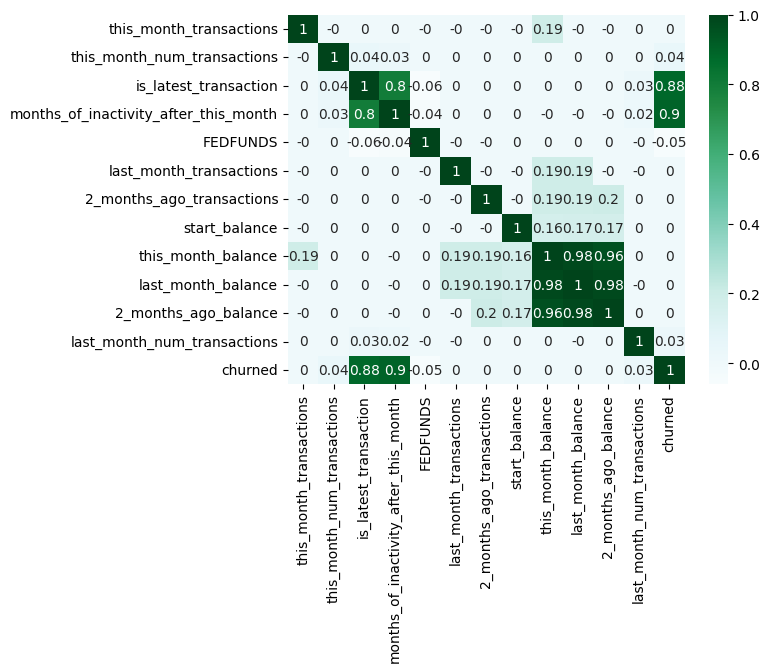

In [163]:
cols = ['this_month_transactions', 
        'this_month_num_transactions', 
        'is_latest_transaction', 
        'months_of_inactivity_after_this_month', 
        'FEDFUNDS', 
        'last_month_transactions',
        '2_months_ago_transactions',
        'dob', 
        'state',
        'start_balance',
        'creation_date',
        'this_month_balance',
        'last_month_balance',
        '2_months_ago_balance', 
        'last_month_num_transactions',
        'churned']
sns.heatmap(round(grp_df[cols].corr(), 2), cmap = 'BuGn', annot = True)
plt.show()